# Import Dataset

In [1]:
from glob import glob
import os

# dataset directories
train_dir = "data/original/training"
test_dir = "data/original/test"

# import image paths
train_image_paths = sorted(glob(os.path.join(train_dir, "*.jpg")))
test_image_paths = sorted(glob(os.path.join(test_dir, "*.jpg")))

# print number of images
print(f"Loaded {len(train_image_paths)} training images")
print(f"Loaded {len(test_image_paths)} test images")


Loaded 88 training images
Loaded 22 test images


# Pre-processing

In [2]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def get_green_screen_region_mask(image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    x1, y1 = 700, 275
    x2, y2 = 1700, 1590
    mask[y1:y2, x1:x2] = 255
    return mask

def extract_largest_human_contour(binary_mask):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return binary_mask

    best_contour = None
    max_score = 0
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        aspect_ratio = h / (w + 1e-5)
        score = area * aspect_ratio
        if score > max_score:
            max_score = score
            best_contour = cnt

    cleaned = np.zeros(binary_mask.shape, dtype=np.uint8)
    if best_contour is not None:
        cv2.drawContours(cleaned, [best_contour], -1, 255, thickness=cv2.FILLED)
    return cleaned

def preprocess_image(image_path, output_dir, size=(640, 480)):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load {image_path}")
            return

        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower_green = np.array([45, 100, 50])
        upper_green = np.array([75, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)
        silhouette_mask = cv2.bitwise_not(green_mask)

        region_mask = get_green_screen_region_mask(image.shape)
        masked = cv2.bitwise_and(silhouette_mask, silhouette_mask, mask=region_mask)

        kernel = np.ones((5, 5), np.uint8)
        masked = cv2.morphologyEx(masked, cv2.MORPH_CLOSE, kernel)

        cleaned = extract_largest_human_contour(masked)
        cleaned = cv2.resize(cleaned, size)

        os.makedirs(output_dir, exist_ok=True)
        filename = os.path.basename(image_path)
        save_path = os.path.join(output_dir, filename)
        cv2.imwrite(save_path, cleaned)

    except Exception as e:
        print(f"Error processing {image_path}: {e}")


def preprocess_images_multithreaded(image_paths, output_dir, max_workers=8):
    os.makedirs(output_dir, exist_ok=True)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(lambda path: preprocess_image(path, output_dir), image_paths))
    return results

# Example usage
train_images = preprocess_images_multithreaded(train_image_paths, "data/manual/training")
test_images = preprocess_images_multithreaded(test_image_paths, "data/manual/test")


# Deeplab version

In [3]:
import os
import cv2
import torch
import torchvision
import numpy as np
from torchvision import transforms
from concurrent.futures import ThreadPoolExecutor

# Load model on GPU once
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).eval().cuda()

# Image preprocessor
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def segment_and_save(image_path, output_dir, size=(640, 480)):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load {image_path}")
            return

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        input_tensor = preprocess(image_rgb).unsqueeze(0).cuda()

        with torch.no_grad():
            output = model(input_tensor)['out'][0]
        pred = output.argmax(0).byte().cpu().numpy()

        # Extract person class (15 in COCO)
        person_mask = (pred == 15).astype(np.uint8) * 255
        person_mask = cv2.resize(person_mask, size, interpolation=cv2.INTER_NEAREST)

        # Save
        filename = os.path.basename(image_path)
        save_path = os.path.join(output_dir, filename)
        cv2.imwrite(save_path, person_mask)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

def process_dataset(input_dir, output_dir, max_workers=8):
    os.makedirs(output_dir, exist_ok=True)
    image_paths = [os.path.join(input_dir, f)
                   for f in os.listdir(input_dir) if f.lower().endswith(('.jpg'))]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for path in image_paths:
            executor.submit(segment_and_save, path, output_dir)


c:\Users\tomev\anaconda3\envs\biometrics\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tomev\anaconda3\envs\biometrics\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
process_dataset("data/original/training", "data/deeplab/training")
process_dataset("data/original/test", "data/deeplab/test")


# Visualistation

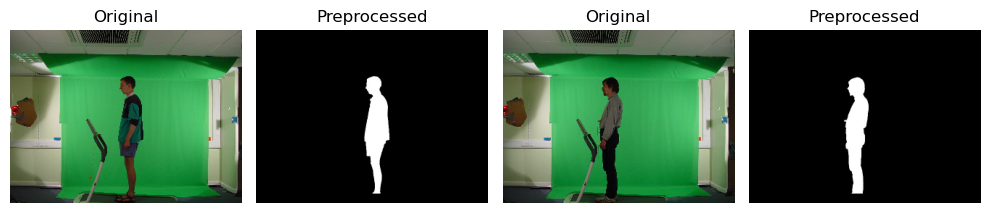

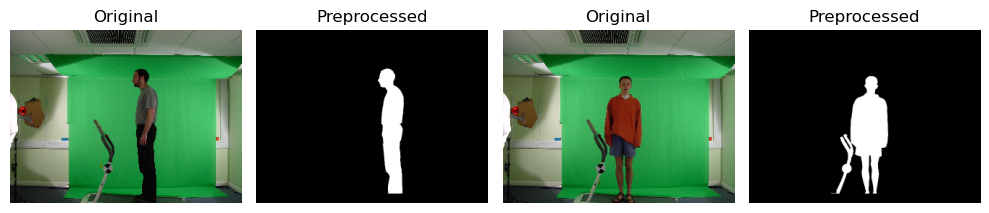

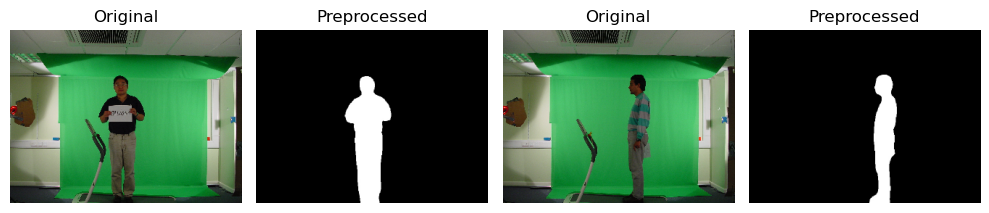

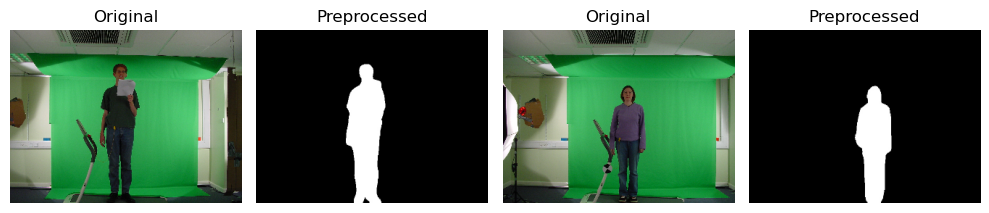

In [15]:
import random
import cv2
import matplotlib.pyplot as plt
import os

def show_preprocessed_examples_from_disk(original_paths, processed_dir, num=2, size=(320, 240)):
    """Displays original and processed silhouette images (loaded from disk) in a side-by-side grid."""
    pairs_per_row = 2
    rows = (num + pairs_per_row - 1) // pairs_per_row

    plt.figure(figsize=(10, rows * 2.5))
    indices = random.sample(range(len(original_paths)), min(num, len(original_paths)))

    for i, idx in enumerate(indices):
        row_offset = (i // pairs_per_row) * (pairs_per_row * 2)
        col_offset = (i % pairs_per_row) * 2

        # Load original
        original = cv2.imread(original_paths[idx])
        original = cv2.cvtColor(cv2.resize(original, size), cv2.COLOR_BGR2RGB)

        # Load processed by matching filename
        filename = os.path.basename(original_paths[idx])
        processed_path = os.path.join(processed_dir, filename)
        processed = cv2.imread(processed_path, cv2.IMREAD_GRAYSCALE)
        processed = cv2.resize(processed, size)

        # Original image
        plt.subplot(rows, pairs_per_row * 2, row_offset + col_offset + 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis('off')

        # Processed image
        plt.subplot(rows, pairs_per_row * 2, row_offset + col_offset + 2)
        plt.imshow(processed, cmap='gray')
        plt.title("Preprocessed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_preprocessed_examples_from_disk(train_image_paths, "data/manual/training")
show_preprocessed_examples_from_disk(test_image_paths, "data/manual/test")
show_preprocessed_examples_from_disk(train_image_paths, "data/deeplab/training")
show_preprocessed_examples_from_disk(test_image_paths, "data/deeplab/test")

# Feature Extraction

In [23]:
import cv2
import numpy as np
from scipy.fft import fft

def extract_features(image, use_hu=True, use_fourier=True, use_width=True, use_aspect=True, num_fourier=10, num_width_samples=20):
    """Extracts toggleable features from a binary silhouette image."""
    features = []

    # Ensure binary image
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Get main contour
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros(1)  # fallback if image is empty
    contour = max(contours, key=cv2.contourArea)

    # Hu Moments
    if use_hu:
        moments = cv2.moments(binary)
        hu = cv2.HuMoments(moments).flatten()
        features.extend(hu)

    # Fourier Descriptors
    if use_fourier:
        cnt = contour.squeeze()
        if len(cnt.shape) == 1:  # safety check
            cnt = cnt[np.newaxis, :]
        complex_cnt = cnt[:, 0] + 1j * cnt[:, 1]
        fourier = fft(complex_cnt)
        desc = np.abs(fourier[:num_fourier])
        features.extend(desc)

    # Width profile
    if use_width:
        h, w = binary.shape
        rows = np.linspace(0, h - 1, num_width_samples, dtype=int)
        width_profile = []
        for y in rows:
            row = binary[y, :]
            x = np.where(row > 0)[0]
            width = x[-1] - x[0] if len(x) > 1 else 0
            width_profile.append(width)
        features.extend(width_profile)

    # Aspect ratio
    if use_aspect:
        x, y, w, h = cv2.boundingRect(contour)
        aspect = h / (w + 1e-5)
        features.append(aspect)

    return np.array(features, dtype=np.float32)

def extract_features_with_correct_labels(image_paths, feature_func, **kwargs):
    X = []
    y = []

    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Skipping unreadable image: {path}")
            continue

        # Extract features
        features = feature_func(image, **kwargs)
        X.append(features)

        # ✅ Extract label from filename (e.g., '016z050pf.jpg' → '050')
        filename = os.path.basename(path)
        label = filename.split('z')[1][:3]  # Grab '050' as label
        y.append(label)

    return np.array(X, dtype=np.float32), np.array(y)

def extract_features_without_labels(image_paths, feature_func, **kwargs):
    X = []
    filenames = []

    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Skipping unreadable image: {path}")
            continue

        features = feature_func(image, **kwargs)
        X.append(features)
        filenames.append(os.path.basename(path))

    return np.array(X, dtype=np.float32), filenames

# Classification

In [25]:
from sklearn.neighbors import KNeighborsClassifier


# dataset directories
train_dir = "data/deeplab/training"
test_dir = "data/deeplab/test"

# import image paths
train_image_paths = sorted(glob(os.path.join(train_dir, "*.jpg")))
test_image_paths = sorted(glob(os.path.join(test_dir, "*.jpg")))

# 2. Extract features
X_train, y_train = extract_features_with_correct_labels(
    train_image_paths,
    extract_features,
    use_hu=True, use_fourier=True, use_width=True, use_aspect=True
)

X_test, test_filenames = extract_features_without_labels(
    test_image_paths,
    extract_features,
    use_hu=True, use_fourier=True, use_width=True, use_aspect=True
)

# 3. Train classifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

# 4. Predict on test set
y_pred = clf.predict(X_test)

In [27]:
import pandas as pd

df = pd.DataFrame({
    "filename": test_filenames,
    "predicted_label": y_pred
})

df.to_csv("test_predictions.csv", index=False)


# Verification

# Evaluation